<a href="https://colab.research.google.com/github/rch16/RecycleHelper/blob/master/Machine%20Learning/Optimised%20Model/wasteclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow.keras
import zipfile as zf
import numpy as np
import seaborn as sns
import pandas as pd

import sys
import cv2
import csv
import os
import re
import shutil
import random
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential 
from tensorflow.data import Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Open Zip File

In [ ]:
files = zf.ZipFile("/content/dataset-resized.zip",'r')
files.extractall()
files.close()

print(files)

<zipfile.ZipFile [closed]>


# Attempt 1

## Helper Functions

The following helper functions were written by Collin Ching for his post "How to build an image classifier for waste sorting"

article : https://towardsdatascience.com/how-to-build-an-image-classifier-for-waste-sorting-6d11d3c9c478

python notebook : https://nbviewer.jupyter.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb

In [ ]:
# splits indices for a folder into train, validation, and test indices with random sampling   
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

# gets file names for a particular type of trash, given indices
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

# moves group of source files to another folder
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
def create_directory(): 
    # paths will be train/cardboard, train/glass, etc...
    subsets = ['train','valid','test']
    waste_types = ['cardboard','glass','metal','paper','plastic','trash']

    # create destination folders for data subset and waste type
    for subset in subsets:
        for waste_type in waste_types:
            folder = os.path.join(data_path,subset,waste_type)
            if not os.path.exists(folder):
                os.makedirs(folder)

    if not os.path.exists(os.path.join(data_path,'test')):
        os.makedirs(os.path.join(data_path,'test'))

    # move files to destination folders for each waste type
    for waste_type in waste_types:
        source_folder = os.path.join(path,waste_type)
        train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)

        # move source files to train
        train_names = get_names(waste_type,train_ind)
        train_source_files = [os.path.join(source_folder,name) for name in train_names]
        train_dest = train_path+"/"+waste_type
        move_files(train_source_files,train_dest)

        # move source files to valid
        valid_names = get_names(waste_type,valid_ind)
        valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
        valid_dest = valid_path+"/"+waste_type
        move_files(valid_source_files,valid_dest)

        # move source files to test
        test_names = get_names(waste_type,test_ind)
        test_source_files = [os.path.join(source_folder,name) for name in test_names]
        test_dest = test_path+"/"+waste_type
        move_files(test_source_files,test_dest)

        # I use data/test here because the images can be mixed up
        move_files(test_source_files,test_path)

In [ ]:
def createFileList(myDir, format='.jpg'):
    fileList = []
    print(myDir)
    for root, dirs, files in os.walk(myDir, topdown=False):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
    return fileList

End of Collin's code

In [ ]:
def stringContains(filePath):
    if "paper" in filePath:
        return 0
    elif "cardboard" in filePath:
        return 1
    elif "trash" in filePath:
        return 2
    elif "plastic" in filePath:
        return 3
    elif "metal" in filePath:
        return 4
    elif "glass" in filePath:
        return 5
    else:
        return 6

def convertToMatrix(fileList,num_images):
    
    num_pixels = 196608
    data = np.empty((num_images,num_pixels))
    labels = []
    label_count = [0,0,0,0,0,0,0]
    index = 0
    
    for file in fileList:
        
        img = Image.open(file) # open image
        arr = np.array(img.convert('L')) # convert to grey and place in numpy array
        vec = arr.ravel() # flatten to vector
        data[index,:] = vec.T # add to matrix
        
        name = stringContains(img.filename) # get image name
        labels = np.append(labels,name) # add to array
        label_count[name] += 1
        
        index += 1

    return data, labels, label_count

## Import Images

In [ ]:
path = "/content/dataset-resized"
data_path = "/content/data"
test_path = "/content/data/test"
train_path = "/content/data/train"
valid_path = "/content/data/valid"

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['plastic', 'metal', 'cardboard', 'trash', '.DS_Store', 'paper', 'glass']

In [ ]:
create_directory()

FileNotFoundError: ignored

In [ ]:
train_files = createFileList(train_path,format='.jpg')
test_files = createFileList(test_path,format='.jpg')
valid_files = createFileList(valid_path,format='.jpg')
fileList = createFileList(path,format='.jpg')

/content/data/train
/content/data/test
/content/data/valid
/content/dataset-resized


In [ ]:
print(len(train_files), "training images")
print(len(test_files), "testing images")
print(len(valid_files), "validation images")

201 training images
101 testing images
101 validation images


## Data Pre-Processing

Convert images to arrays

In [ ]:
train,train_l,train_count = convertToMatrix(train_files,1262)
test,test_l,test_count = convertToMatrix(test_files,635)
valid,valid_l,valid_count = convertToMatrix(valid_files,630)

train = train.astype('float32')
train_l = train_l.astype('uint8')
test = test.astype('float32')
test_l = test_l.astype('uint8')
valid = valid.astype('float32')
valid_l = valid_l.astype('uint8')

print("data")
print(train.shape)
print(test.shape)
print(valid.shape)

print("")

print("labels")
print(train_l.shape)
print(test_l.shape)
print(valid_l.shape)

print("")
print("count")
print(train_count)
print(test_count)
print(valid_count)

NameError: ignored

NameError: ignored

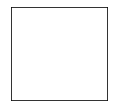

In [ ]:
class_names = ['paper', 'cardboard', 'trash', 'plastic', 'metal','glass']

random_idx = []
for i in range(25):
    random.seed(i)
    random_idx.append(random.randrange(0,1262))
    
plt.figure(figsize=(10,10))
for i in range(25):
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    idx = random_idx[i]
    image = train[idx].reshape((384,512))
    plt.imshow(image)
    plt.xlabel(class_names[train_l[idx]])
    
plt.show()

Convert labels to one hot encoding

In [ ]:
train_labels = to_categorical(train_l).astype('uint8')
test_labels = to_categorical(test_l).astype('uint8')
valid_labels = to_categorical(valid_l).astype('uint8')

print("Labels:")
print("train", train_l.shape)
print("test", test_l.shape)
print("validate", valid_l.shape)

print("")

print("One Hot Encoded Labels:")
print("train", train_labels.shape)
print("test", test_labels.shape)
print("validate", valid_labels.shape)

print("")

print(train_l[0])
print(train_labels[0])

Reshape data

In [ ]:
rows = 384
cols = 512

## channel last configuration
train_data = train.reshape(train.shape[0],rows,cols,1)
test_data = test.reshape(test.shape[0],rows,cols,1)
valid_data = valid.reshape(valid.shape[0],rows,cols,1)

Normalise data

In [ ]:
train_data /= 255.0
test_data /= 255.0
valid_data /= 255.0

print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

## Model Training

In [ ]:
# input data
n_classes = 6
rows = 384
cols = 512
input_shape = (rows,cols,1)

# hyperparameters
batch_size = 75
epochs = 300
dropout_prob = 0.2
lr = 0.001
m = 0.2

# model architecture
opt = tensorflow.keras.optimizers.SGD(learning_rate=lr, momentum=m)
pool_size = 2
num_filters1 = 32
num_filters2 = 64
num_filters3 = 128
filter_size = 5
filter_size = 5

In [ ]:
print('train ',train_count[0:6])
print('test ',test_count[0:6])
print('validate ',valid_count[0:6])

In [ ]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', np.unique(train_l), train_l)

weights_dict = dict(enumerate(weights))

print(weights_dict)

In [ ]:
def waste_classifier_model(): 
    model = Sequential()

    model.add(InputLayer(input_shape=input_shape))

    model.add(Dropout(dropout_prob))

    model.add(Conv2D(num_filters1,filter_size,activation='relu',data_format="channels_last"))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Conv2D(num_filters2,filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))

    # the output softmax layer will have one node for each class
    model.add(Flatten())
    model.add(Dense(n_classes,activation='softmax'))
    
    opt = tensorflow.keras.optimizers.SGD(learning_rate=lr, momentum=m)
    model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])

    model.summary()

    return model

Convert to tensorflow dataset

In [ ]:
train_dataset = Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = Dataset.from_tensor_slices((test_data, test_labels))
valid_dataset = Dataset.from_tensor_slices((valid_data, valid_labels))

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

print(train_dataset)


In [ ]:
model = waste_classifier_model()
model.fit(train_dataset,epochs=epochs,
          class_weights=weights_dict,
          verbose=2)

# Attempt 2

## Data Pre-Processing

In [ ]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator = train.flow_from_directory("/content/dataset-resized",
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator = test.flow_from_directory("/content/dataset-resized",
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

## Model Training

In [ ]:
# input data
n_classes = 6
rows = 384
cols = 512
input_shape = (rows,cols,1)

# hyperparameters
batch_size = 75
epochs = 200
dropout_prob = 0.2
lr = 0.001
m = 0.2

In [ ]:
def waste_classifier_model_2():
    model=Sequential()

    #model.add(InputLayer(input_shape=(300,300,3)))

    #Convolution blocks

    model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=2)) 
    #model.add(SpatialDropout2D(0.5)) # No accuracy

    model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=2)) 
    #model.add(SpatialDropout2D(0.5))

    model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=2)) 

    #Classification layers
    model.add(Flatten())

    model.add(Dense(64,activation='relu'))
    #model.add(SpatialDropout2D(0.5))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(6,activation='softmax'))

    opt = tensorflow.keras.optimizers.SGD(learning_rate=lr, momentum=m)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])

    model.summary()

    return model

In [ ]:
K.clear_session()
waste_model = waste_classifier_model_2()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43808)             0

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

filepath="waste_classifier_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

Train the model


In [ ]:
result = waste_model.fit(train_generator,
                         epochs=epochs,
                         steps_per_epoch=2276//32,
                         validation_data=test_generator,
                         validation_steps=251//32,
                         workers=4,
                         callbacks=callbacks_list,
                         verbose=2)

Epoch 1/200

Epoch 00001: val_acc improved from 0.50893 to 0.52232, saving model to waste_classifier_model.h5
71/71 - 39s - loss: 1.2838 - acc: 0.5004 - val_loss: 1.2905 - val_acc: 0.5223
Epoch 2/200

Epoch 00002: val_acc did not improve from 0.52232
71/71 - 39s - loss: 1.2824 - acc: 0.4982 - val_loss: 1.2754 - val_acc: 0.4911
Epoch 3/200

Epoch 00003: val_acc did not improve from 0.52232
71/71 - 38s - loss: 1.3028 - acc: 0.4951 - val_loss: 1.2703 - val_acc: 0.4777
Epoch 4/200

Epoch 00004: val_acc did not improve from 0.52232
71/71 - 38s - loss: 1.2693 - acc: 0.5036 - val_loss: 1.2975 - val_acc: 0.4777
Epoch 5/200

Epoch 00005: val_acc did not improve from 0.52232
71/71 - 39s - loss: 1.2710 - acc: 0.5013 - val_loss: 1.3435 - val_acc: 0.4732
Epoch 6/200

Epoch 00006: val_acc did not improve from 0.52232
71/71 - 38s - loss: 1.2777 - acc: 0.5071 - val_loss: 1.2621 - val_acc: 0.5179
Epoch 7/200

Epoch 00007: val_acc did not improve from 0.52232
71/71 - 39s - loss: 1.2841 - acc: 0.4880 - v

# Results Analysis

In [ ]:
test_loss, test_acc = waste_model.evaluate(test_generator)

print("Test accuracy:", test_acc)

8/8 [==============================] - 1s 108ms/step - loss: 0.9251 - acc: 0.6733
Test accuracy: 0.6733067631721497


In [ ]:
acc = result.history['acc']
val_acc = result.history['val_acc']

loss = result.history['loss']
val_loss = result.history['val_loss']


Text(0.5, 1.0, 'Accuracy')

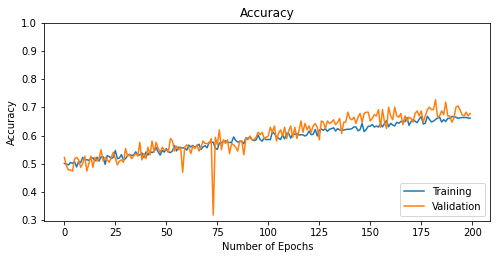

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy')


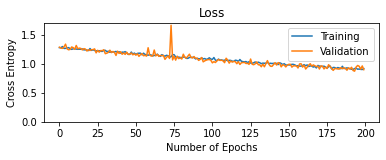

In [ ]:
# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Number of Epochs')
plt.ylim([0,max(plt.ylim())])
plt.title('Loss')
plt.show()

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [ ]:
predictions = waste_model.predict(test_generator)

predicted = predictions.argmax(axis=-1)
actual = test_generator.classes
class_labels = test_generator.class_indices

print(predicted.shape)
print(actual)

print("")

print(class_labels)

(251,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5]

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


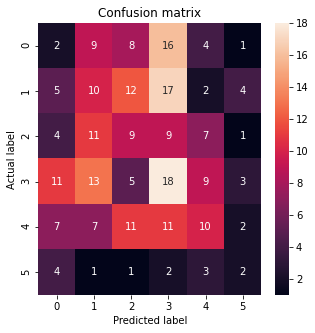

In [ ]:
plot_cm(actual,predicted)